In [21]:
from yucca.modules.data.augmentation.transforms import (
    Torch_BiasField,
    Torch_Blur,
    Torch_CropPad,
    Torch_Gamma,
    Torch_MotionGhosting,
    Torch_Mask,
    Torch_GibbsRinging,
    Torch_SimulateLowres,
    Torch_Spatial,
)


from nibabel.testing import data_path
import nibabel as nib
import os
from copy import deepcopy
import numpy as np
import timeit
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Compose

np.random.seed(4215235)
iterations = 1

example_file = os.path.join(data_path, "example4d.nii.gz")
im_real = torch.tensor(nib.load(example_file).get_fdata()[:, :, :, 0], dtype=torch.float)
print(im_real.shape)

dd_real = {"image": im_real.unsqueeze(0)}
im_notreal_gpu = torch.randn((2, 256, 256, 256), dtype=torch.float).to("mps")
seg_notreal_gpu = torch.randint(0, 4, (1, 256, 256, 256), dtype=torch.int).to("mps")
dd_fake_gpu = {"image": im_notreal_gpu, "label": seg_notreal_gpu}

im_notreal_cpu = im_notreal_gpu.clone().to("cpu")
seg_notreal_cpu = seg_notreal_gpu.clone().to("cpu")
dd_fake_cpu = {"image": im_notreal_cpu, "label": seg_notreal_cpu}

torch.Size([128, 96, 24])


In [22]:
def plot(dd):
    plt.imshow(dd["image"][0, :, :, 12], cmap="gray")
    plt.show()


def test_tf(tform, real, fake_on_cpu, fake_on_gpu):
    print(
        "tform gpu: ",
        timeit.timeit(lambda: tform(deepcopy(fake_on_gpu)), number=iterations) / iterations,
        "\n ",
        "tform cpu: ",
        timeit.timeit(lambda: tform(deepcopy(fake_on_cpu)), number=iterations) / iterations,
    )

    tf_real = tf(deepcopy(real))
    plot(tf_real)

tform gpu:  0.004468916973564774 
  tform cpu:  0.11720112501643598


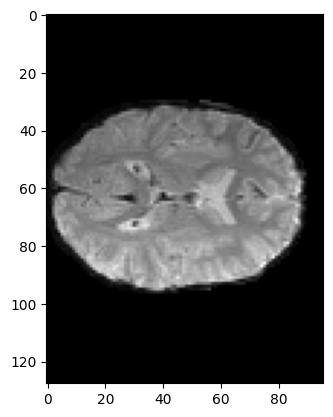

In [23]:
tf = Torch_BiasField(p_per_channel=1)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.08345254196319729 
  tform cpu:  3.525078750040848


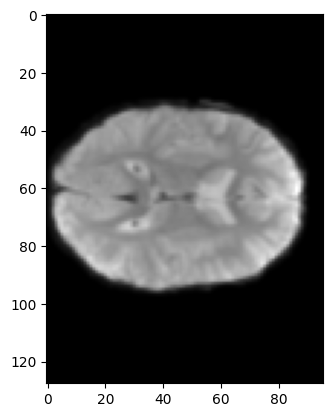

In [24]:
tf = Torch_Blur(p_per_channel=1.0)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.0016791660455055535 
  tform cpu:  0.07368391699856147


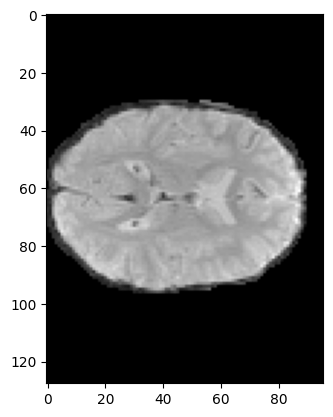

In [25]:
tf = Torch_Gamma(p_all_channel=1)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.04128791601397097 
  tform cpu:  0.7091480829985812


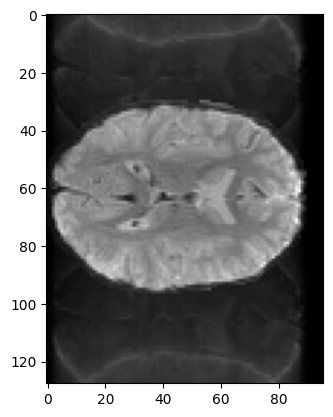

In [26]:
tf = Torch_MotionGhosting(p_per_channel=1, alpha=(2.0, 3.0), num_reps=(3, 4), axes=(0, 1))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.17162470798939466 
  tform cpu:  0.7896033749566413


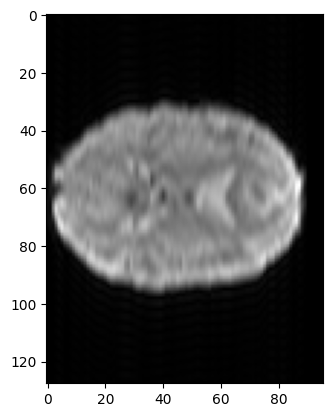

In [27]:
tf = Torch_GibbsRinging(p_per_channel=1, cut_freq=(32, 34), axes=(0, 1))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.01437604200327769 
  tform cpu:  0.07850829098606482


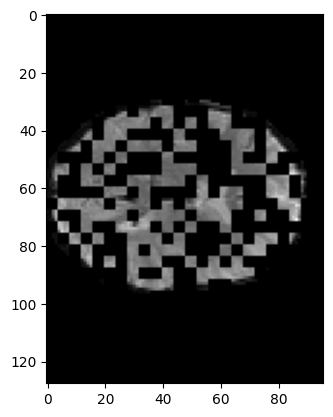

In [28]:
tf = Torch_Mask(ratio=0.5)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.07723462500143796 
  tform cpu:  0.05295645899605006


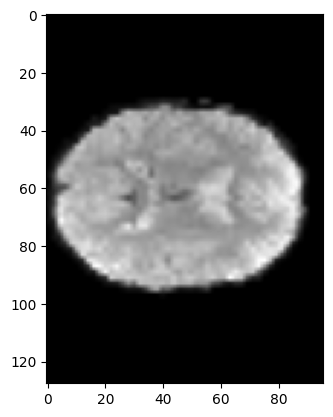

In [29]:
tf = Torch_SimulateLowres(p_per_channel=1, p_per_axis=1, zoom_range=(0.5, 0.51))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.17361041699768975 
  tform cpu:  0.1771619159844704


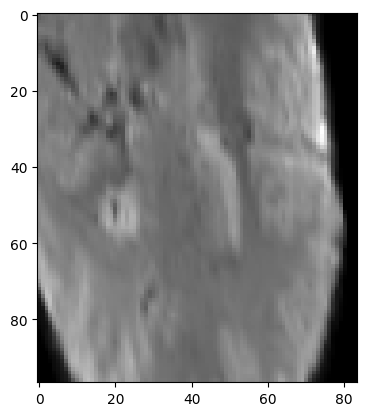

In [30]:
tf = Torch_Spatial(
    patch_size=(97, 84, 24), p_deform_all_channel=1, p_rot_all_channel=1, p_rot_per_axis=1, p_scale_all_channel=0
)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

/Users/zcr545/miniconda3/envs/yuccaenv/lib/python3.11/site-packages/torch/nn/functional.py:4522: UserWarning: MPS: The constant padding of more than 3 dimensions is not currently supported natively. It uses View Ops default implementation to run. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1709105852207/work/aten/src/ATen/native/mps/operations/Pad.mm:472.)
  return torch._C._nn.pad(input, pad, mode, value)


tform gpu:  0.9315054590115324 
  tform cpu:  0.8133929999894463


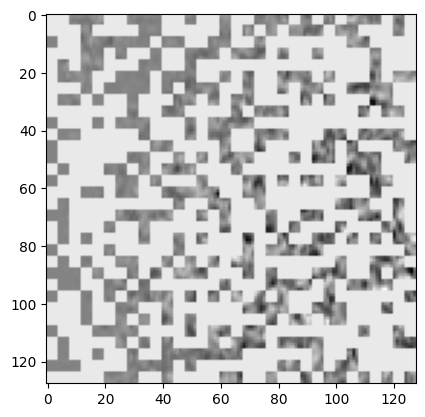

In [ ]:
tf = Compose(
    [
        Torch_CropPad(patch_size=(168, 168, 168)),
        Torch_Spatial(
            patch_size=(128, 128, 128),
            p_deform_all_channel=0,
            p_rot_all_channel=1,
            p_rot_per_axis=1,
            p_scale_all_channel=1,
        ),
        Torch_BiasField(p_per_channel=1.0),
        Torch_Blur(p_per_channel=1.0),
        Torch_Gamma(p_all_channel=1),
        Torch_MotionGhosting(p_per_channel=1, alpha=(0.7, 0.8), num_reps=(2, 3), axes=(0, 1)),
        Torch_GibbsRinging(p_per_channel=1, cut_freq=(64, 68), axes=(0, 1)),
        Torch_SimulateLowres(p_per_channel=1, p_per_axis=1, zoom_range=(0.8, 0.9)),
        Torch_Mask(),
    ]
)
test_tf(tf, real=dd_fake_cpu, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F


def croppad_3D_case_from_3D(
    image,
    foreground_locations,
    label,
    patch_size,
    p_oversample_foreground,
    target_image_shape,
    target_label_shape,
    **pad_kwargs,
):
    image_out = torch.zeros(target_image_shape, device=image.device)
    label_out = torch.zeros(target_label_shape, device=image.device)

    # First we pad to ensure min size is met
    to_pad = []
    for d in range(3):
        if image.shape[d + 1] < patch_size[d]:
            to_pad += [patch_size[d] - image.shape[d + 1]]
        else:
            to_pad += [0]

    pad_lb_x = to_pad[0] // 2
    pad_ub_x = to_pad[0] // 2 + to_pad[0] % 2
    pad_lb_y = to_pad[1] // 2
    pad_ub_y = to_pad[1] // 2 + to_pad[1] % 2
    pad_lb_z = to_pad[2] // 2
    pad_ub_z = to_pad[2] // 2 + to_pad[2] % 2

    # This is where we should implement any patch selection biases.
    # The final patch excted after augmentation will always be the center of this patch
    # to avoid interpolation artifacts near the borders
    crop_start_idx = []
    if len(foreground_locations) == 0 or np.random.uniform() >= p_oversample_foreground:
        for d in range(3):
            if image.shape[d + 1] < patch_size[d]:
                crop_start_idx += [0]
            else:
                crop_start_idx += [np.random.randint(image.shape[d + 1] - patch_size[d] + 1)]
    else:
        location = select_foreground_voxel_to_include(foreground_locations)
        for d in range(3):
            if image.shape[d + 1] < patch_size[d]:
                crop_start_idx += [0]
            else:
                crop_start_idx += [
                    np.random.randint(
                        max(0, location[d] - patch_size[d]),
                        min(location[d], image.shape[d + 1] - patch_size[d]) + 1,
                    )
                ]

    image_out[
        :,
        :,
        :,
        :,
    ] = F.pad(
        image[
            :,
            crop_start_idx[0] : crop_start_idx[0] + patch_size[0],
            crop_start_idx[1] : crop_start_idx[1] + patch_size[1],
            crop_start_idx[2] : crop_start_idx[2] + patch_size[2],
        ],
        (
            pad_lb_z,
            pad_ub_z,
            pad_lb_y,
            pad_ub_y,
            pad_lb_x,
            pad_ub_x,
            0,
            0,
        ),
        **pad_kwargs,
    )
    if label is None:
        return image_out, None
    label_out[
        :,
        :,
        :,
        :,
    ] = F.pad(
        label[
            :,
            crop_start_idx[0] : crop_start_idx[0] + patch_size[0],
            crop_start_idx[1] : crop_start_idx[1] + patch_size[1],
            crop_start_idx[2] : crop_start_idx[2] + patch_size[2],
        ],
        (
            pad_lb_z,
            pad_ub_z,
            pad_lb_y,
            pad_ub_y,
            pad_lb_x,
            pad_ub_x,
            0,
            0,
        ),
    )
    return image_out, label_out


patch_size = (168, 168, 168)
x = croppad_3D_case_from_3D(
    image=im_notreal_gpu,
    foreground_locations=[],
    label=seg_notreal_gpu,
    patch_size=(168, 168, 168),
    p_oversample_foreground=0.0,
    target_image_shape=(im_notreal_gpu.shape[0], *patch_size),
    target_label_shape=(seg_notreal_gpu.shape[0], *patch_size),
)
iterations = 100
timeit.timeit(
    lambda: croppad_3D_case_from_3D(
        image=im_notreal_gpu,
        foreground_locations=[],
        label=seg_notreal_gpu,
        patch_size=(168, 168, 168),
        p_oversample_foreground=0.0,
        target_image_shape=(im_notreal_gpu.shape[0], *patch_size),
        target_label_shape=(seg_notreal_gpu.shape[0], *patch_size),
    ),
    number=iterations,
) / iterations,

(0.00714193084044382,)